<a href="https://colab.research.google.com/github/ashishar/q_character/blob/main/mnist_with_qnn_with_lateral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# !pip install torchvision
# !pip install qiskit-machine-learning
import importlib

# Check if torchvision is installed
try:
    importlib.import_module('torchvision')
    print("torchvision is already installed.")
except ImportError:
    print("torchvision is not installed. Installing...")
    # Install torchvision using pip
    try:
        import pip
        pip.main(['install', 'torchvision'])
        print("torchvision installed successfully.")
    except Exception as e:
        print("Error occurred while installing torchvision:", str(e))

try:
    importlib.import_module('qiskit')
    print("qiskit is already installed.")
except ImportError:
    print("qiskit is not installed. Installing...")
    # Install torchvision using pip
    try:
        import pip
        pip.main(['install', 'qiskit'])
        print("qiskit installed successfully.")
    except Exception as e:
        print("Error occurred while installing qiskit:", str(e))

# try:
#     importlib.import_module('qiskit_machine_learning')
#     print("qiskit-machine-learning is already installed.")
# except ImportError:
#     print("qiskit-machine-learning is not installed. Installing...")
#     # Install torchvision using pip
#     try:
#         import pip
#         pip.main(['install', 'qiskit-machine-learning'])
#         print("qiskit-machine-learning installed successfully.")
#     except Exception as e:
#         print("Error occurred while installing qiskit-machine-learning:", str(e))


torchvision is already installed.
qiskit is already installed.


In [10]:
# prompt: mount gdrive and import a file named quantum_circuit_simulator.py

from google.colab import drive
drive.mount('/content/drive')

# Change directory to the desired location where the file is stored.
%cd /content/drive/MyDrive/

# Import the file named quantum_circuit_simulator.py
import quantum_circuit_simulator


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [11]:
import numpy as np
import matplotlib.pyplot as plt

import time, copy

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.dataset import random_split


from quantum_circuit_simulator import quantum_circuit

In [35]:
# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the MNIST dataset

mnist_dataset= datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Select 1000 random images from the dataset
random_indices = np.random.choice(len(mnist_dataset), size=13000, replace=False)
reduced_dataset = torch.utils.data.Subset(mnist_dataset, random_indices)
train_dataset, test_dataset = torch.utils.data.random_split(reduced_dataset, [10000, 3000])


# Create a DataLoader for the random subset
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Load the MNIST dataset
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Select 1000 random images from the dataset
# random_indices = np.random.choice(len(testset), size=3000, replace=False)
# test_dataset = torch.utils.data.Subset(testset, random_indices)

# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

x of torch.Size([1, 28, 28]) :


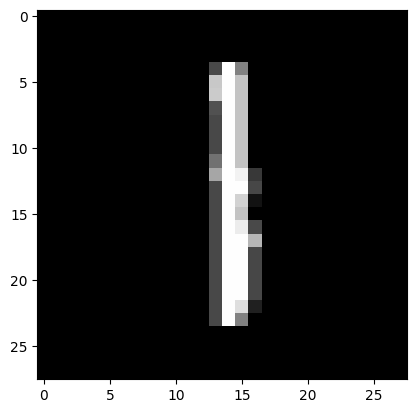

true label = y = 1

(x_min, x_max) =  (0.0, 0.996)


In [13]:
idx = np.random.choice(len(train_dataset))

# Access the data and label using the selected index
x, y = train_dataset[idx]

# Display the image
print(f'x of {x.shape} :')
plt.imshow(x.squeeze(), cmap='gray')  # Assuming MNIST images are grayscale (1 channel)
plt.show()

# Print the true label
print(f'true label = y = {y}\n')

# Print the minimum and maximum pixel values
print(f'(x_min, x_max) =  {x.min().item(), round(x.max().item(), 3)}')

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"    # Get gpu or cpu device for training
print(f"Using {device} device\n")

import torchvision.transforms.functional as TF
from skimage.feature import hog



# Define a function to compute HOG features for an image
def compute_hog_features(image):
    features, _ = hog(image, orientations=12, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    return features

#=====================================================================================


class QNN(torch.nn.Module):                              # Define model
    def __init__(self, n, L):                            # number of qubits = n, number of quantum layers = L
        super().__init__()

        self.flatten = nn.Flatten()

        angles = torch.empty((L, n), dtype=torch.float64)
        torch.nn.init.uniform_(angles, -0.01, 0.01)
        self.angles = torch.nn.Parameter(angles)                   # it makes angles learnable parameters

        # self.fc1 = nn.Linear(1024, 1024)
        # self.fc2 = nn.Linear(784,512)
        # self.fc3 = nn.Linear(512, 1024)

        self.linear = nn.Linear(2**n, 10)                          # classical linear layer


    def forward(self, x):
        x=x.squeeze(1)
        #x = F.pad(x, (2 ,2, 2, 2), "constant", 0)                  # (left, right, top, bottom) padding
        x_projection = torch.sum(x, dim=1).to(device)  # Calculate x-axis projection
        #print("x_projection ",x_projection.shape, x.shape)
        #x_projection = x_projection / torch.norm(x_projection, p=1)
        y_projection = torch.sum(x, dim=2).to(device)  # Calculate x-axis projection
        #y_projection = y_projection / torch.norm(y_projection, p=1)
        #print("y_projection ",y_projection.shape)
        #angle projection
        rotated_images1 = TF.rotate(x,30).to(device)
        rotated_images2 = TF.rotate(x,45).to(device)
        rotated_images3 = TF.rotate(x,60).to(device)

        #rotated projections
        rotated_projection1=torch.sum(rotated_images1, dim=2).to(device)
        rotated_projection2=torch.sum(rotated_images2, dim=2).to(device)
        rotated_projection3=torch.sum(rotated_images3, dim=2).to(device)

        #rotated_images = torch.sum(torch.stack([TF.rotate(img, angle) for img in inputs]))
        x_image=x.cpu().numpy()
        hog_features = [compute_hog_features(np.squeeze(image)) for image in x_image]
        hog_features_tensor = torch.tensor(np.array(hog_features), dtype=torch.float32).to(device)
        #print(hog_features_tensor.shape)

        x = self.flatten(x)
        x = x[:, :-92]

        # print("sizes ",x.shape, y_projection.shape, rotated_projection1.shape,rotated_projection2.shape,
        #      rotated_projection3.shape,hog_features_tensor.shape)

        combined_projection=torch.cat((x,x_projection,y_projection, rotated_projection1,rotated_projection2,rotated_projection3,
                                       torch.zeros(x.shape[0],0),hog_features_tensor), dim=1)

        #print("combined ", combined_projection.shape)
        #x = self.flatten(x)
        combined_projection /= torch.linalg.norm(x.clone(), ord=2, dim=1, keepdim=True)   # L2 normalization to change x --> |x⟩

        # combined_projection = torch.sigmoid(self.fc1(combined_projection))
        # x1 = torch.sigmoid(self.fc2(x1))
        # x1 = torch.sigmoid(self.fc3(x1))

        '''initializing parameterized quantum circuits (PQC)'''

        qc = quantum_circuit(num_qubits = n, state_vector = combined_projection.T)   # each column is a feature-vector of an example
        for l in range(L):
            qc.Ry_layer(self.angles[l].to(torch.cfloat))           # rotation part of lth quantum layer
            qc.cx_linear_layer()                                   # entangling part of lth quantum layer

        'after passing through the PQC, measurement on the output-ket in the computational basis'
        x = torch.real(qc.probabilities())               # each column is a probabilities-vector for an example
                                                         # x.shape = (dim, batch size)

        #print(torch.sum(x, dim=0))                      # to see whether probabilities add up to 1 or not

        x = self.linear(x.T)                           # x.shape = (batch size, 10),  classical linear layer

        return x

Using cpu device



In [57]:
def performance_estimate(dataset, model, loss_fn, train_or_test):
    '''this function computes accuracy and loss of a model on the training or test set'''
    data_size = len(dataset)

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(dataloader)

    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            accuracy += (pred.argmax(1) == y).sum().item()
            loss += loss_fn(pred, y).item()
    accuracy /= data_size                                            # accuracy lies in the interval [0, 1]
    loss /= num_batches
    print(f"{train_or_test} accuracy: {round(accuracy, 3)},  {train_or_test} loss: {round(loss,3)}")
    return accuracy, loss




def one_epoch(model, loss_fn, optimizer, train_dataset, test_dataset, batch_size):

    A_train, L_train, A_test, L_test = [], [], [], []

    dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        out = model(X)                             # Perform a single forward pass
        loss = loss_fn(out, y)

        optimizer.zero_grad()                      # Clear gradients
        loss.backward()                            # Derive gradients, backpropagation
        optimizer.step()                           # Update parameters based on gradients


        if batch % batch_size == 0:
            #As training progress, computing and appending loss and accuracy of the model on train and test set
            accuracy_train, loss_train = performance_estimate(train_dataset, model, loss_fn, 'train')
            accuracy_test, loss_test = performance_estimate(test_dataset, model, loss_fn, 'test ')
            print()

            A_train.append(accuracy_train)
            L_train.append(loss_train)
            A_test.append(accuracy_test)
            L_test.append(loss_test)

            #print(f"train loss: {round(loss,3)}")

    return A_train, L_train, A_test, L_test



def training(train_dataset, test_dataset, batch_size, n, L, lr_, weight_decay_, epochs):

    model = QNN(n=n, L=L).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_, weight_decay=weight_decay_)

    A_Train, L_Train, A_Test, L_Test = [], [], [], []
    for t in range(epochs):
        print(f"Epoch {t+1} ---------------------------------- \n")
        #As training progress, computing and appending loss and accuracy of the model on train and test set
        A_train, L_train, A_test, L_test = one_epoch(model, loss_fn, optimizer, train_dataset, test_dataset, batch_size)
        A_Train += A_train
        L_Train += L_train
        A_Test += A_test
        L_Test += L_test

        #accuracy, loss = performance_estimate(test_dataset, model, loss_fn, 'test ')

    model_state_dict = model.state_dict()           # for saving or loading the trained model

    return A_Train, L_Train, A_Test, L_Test, model_state_dict

In [ ]:
%%time

n = 10
dim = 2**n              # dimension of the n-qubit Hilbert space
L = 2

n_angs = n*L

print("number of qubits = ", n)
print("number of quantum layers = ", L)
print(f"number of angles (learnable parameters of quantum circuit) = {n_angs}\n ")

#--------------------------------------------------------------------------------------


batch_size = 64
print(f'batch_size = {batch_size}\n')


#----------------------------------------------------------------------------------


A_Train, L_Train, A_Test, L_Test, model_state_dict = training(train_dataset, test_dataset, batch_size=batch_size, n=n, L=L,
                                                              lr_=0.01, weight_decay_=1e-10, epochs=30)


print(f' ~~~~~ training is done ~~~~~\n')

number of qubits =  10
number of quantum layers =  2
number of angles (learnable parameters of quantum circuit) = 20
 
batch_size = 64

Epoch 1 ---------------------------------- 

train accuracy: 0.134,  train loss: 2.207
test  accuracy: 0.127,  test  loss: 2.206

train accuracy: 0.829,  train loss: 0.69
test  accuracy: 0.81,  test  loss: 0.72



In [ ]:
plt.plot(A_Train, label='train set')
plt.plot(A_Test, label='test set')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(L_Train, label='train set')
plt.plot(L_Test, label='test set')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
idx = np.random.choice(len(test_dataset))

x = test_dataset[idx][0]
print(f'x of {x.shape} :')
plt.imshow(x[0], cmap='gray')
plt.show()

print(f'true label = y = {test_dataset[idx][1]}\n')


out_ = model(x.view(1, 1, 28, 28)).detach().flatten()
prob = F.softmax(out_, dim=0)
pred = prob.argmax().item()
print(f'predicted label = {pred}\n')

plt.stem(np.arange(10), prob)
plt.ylabel('probability')
plt.xlabel('class labels')
plt.show()

In [ ]:
2048-1056+32
